# Importing libraries and defining classes and functions

Welcome to $B, \tau, \nu$ Analysis.

This notebook is developed in order to make an Analysis for MC simulations for final state $b_{jet}, \tau_h, p_T^{miss}$. 
In this first section a user only must care about giving the path direction for storing the histograms and de DataFrames in a .csv format.

The path is declared in the first line of the second code cell, just before the `RootTreeReader`.

Once the user had made that, the resulting files will be uploaded in the path.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward
import mplhep as hep
hep.style.use("CMS")

In [2]:
Path_files = "C:/Users/toatg/Documents/DataFrames_Thesis/SSM"


class RootTreeReader:

    """ 
    Read data from a ROOT TTree 
    Parameters:
    path : string
        Path to the ROOT file
    tree_name : string (default=Delphes)
        Name of the ROOT TTree
    Attributes:
    tree: Root TTree 
    """

    def __init__(self, path: str, tree_name: str = "Delphes"):
        self.tree = uproot.open(path)[tree_name]


    def get_branches(self, branches = ["MissingET.MET",
                                       "MissingET.Eta",
                                       "MissingET.Phi",
                                       "Jet.PT",
                                       "Jet.Eta",
                                       "Jet.Phi",
                                       "Jet.Mass",
                                       "Jet.TauTag",
                                       "Jet.BTag",
                                       "Jet_size"], max_elements=4):
        """
        returns a DataFrame with branches as features
        branches : array-like
          branches to load from the ROOT tree
        max_elements : int (default=4)
          maximum number of elements to load from jagged arrays
        """   
        self._max_elements = max_elements
        self._df = pd.DataFrame(index=range(self.tree.num_entries))

        for branch in branches:
            self._join_branch(branch)

        return self._set_columns_names(self._df)


    def _join_branch(self, branch):
        """joins a branch to self._df"""
        df = self.tree.arrays(branch, library="pd")

        if "." in branch:
            if len(df) > len(df.groupby(level=0).size()):
                self._add_jagged_branch(df, branch)
            else:
                self._add_branch(df, branch)
        else:
            self._add_branch(df, branch)


    def _add_branch(self, df, branch: str):
        """adds a non-jagged branch to self.df"""
        self._df[branch] = self.tree[branch].array(library="pd").values


    def _add_jagged_branch(self, df, branch):
        """adds a jagged branch to self.df"""
        df = df.unstack().iloc[:,:self._max_elements]
        df.columns = ["{0}{1}".format(branch, i) for i in range(self._max_elements)]
        self._df = self._df.join(df)

    @staticmethod
    def _set_columns_names(df):
        df.columns = df.columns.str.lower().str.replace(".","_")
        return df


def build_df(path):
    """
    Generates a Dataframe from the root in "path"
    """
    reader = RootTreeReader(path)
    df = reader.get_branches()
    df['n_tau'] = np.sum(df.loc[:,"jet_tautag0":"jet_tautag3"],axis = 1)
    df['n_b'] = np.sum(df.loc[:,"jet_btag0":"jet_btag3"],axis = 1)
    return df

In [3]:
def tau_cut(df, val = 0):
    mask = (df.n_tau > val) & (df.jet_tau_index1 >= 0)
    return df.loc[mask]

def b_cut(df, val = 0):
    mask = (df.n_b > val) & (df.jet_b_index1 >= 0)
    return df.loc[mask]


#Cuts over the final Df

def pt_tau_cut(df, val = 25):
    # leading jets pt > 30 GeV
    mask = df.tau1_pT > val
    return df.loc[mask]


def pt_b_cut(df, val = 30):
    # leading jets pt > 30 GeV
    mask = df.b_pT > val
    return df.loc[mask]


def eta_tau_cut(df, val = 2.4):
    # leading jets eta < 2.4
    mask = np.abs(df.tau1_eta) < val
    return df.loc[mask]


def eta_b_cut(df, val = 2.1):
    # leading jets eta < 2.4
    mask = np.abs(df.b_eta) < val
    return df.loc[mask]


def phi_tau_cut(df, val= 2.0):
    # delta phi between met and tau > 2.0
    mask = np.abs(df.Delta_phi_Tau_Met) > val
    return df.loc[mask]


def et_met_cut(df, val = 200):
    # Met et greater than 200
    mask = df.met_Met > val
    return df.loc[mask]


def final_cuts(df, pt_tau = 25, pt_b = 20, eta_tau = 2.3, eta_b = 2.5, met = 150, del_phi = 1.0):
    """
    Returns a copy of the df filtered by different variables and different objects
    Parameters:
        df : A Pandas.Dataframe to be filtered. This DataFrame must have a series of columns named as 
             'tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 'b_pT' ,'b_eta' ,'b_phi' ,
             'b_mass','met_Met' ,'met_Phi' ,'met_Eta', 'n_tau', 'n_b'.
        pt_tau : Minimun value for tau's p_T.
        pt_b : Minimun value for b's p_T.
        eta_tau : Minimun value for tau's eta.
        eta_b : Minimun value for b's eta.
        met : Minimun value for p_T^{miss}. 
        del_phi : Minimun value for absolute value of delta phi between tau and met.
    """
    cut_df = df.copy()
    cut_df = pt_tau_cut(cut_df, pt_tau)
    cut_df = pt_b_cut(cut_df, pt_b)
    cut_df = eta_tau_cut(cut_df, eta_tau)
    cut_df = phi_tau_cut(cut_df, del_phi)
    cut_df = eta_b_cut(cut_df, eta_b)
    cut_df = et_met_cut(cut_df, met)
    return cut_df



def branch_index(df, branch):
    """
    Adds a column with the index of the first jet tagged as branch to the df.

    Branch:
    takes values of "jet_btag" or "jet_tautag"

    Ex:
    branch_index(cut_df, "jet_tautag")
    Returns a df with a column with the first jet tagged as tau per ivent
    """
    branch_jets = df[[f"{branch}{i}" for i in range(4)]].copy()

    # events with branch jets
    branch_events1 = branch_jets[branch_jets.sum(axis=1) > 0]
    
    # events with more tah 1 branch jets
    branch_events2 = branch_jets[branch_jets.sum(axis=1) > 1]

    # index of first branch jet
    branch_index1 = branch_events1.apply(lambda x: x > 0).apply(lambda x: np.nonzero(x.values)[0][0], axis=1)
    
    # index of first branch jet
    branch_index2 = branch_events2.apply(lambda x: x > 0).apply(lambda x: np.nonzero(x.values)[0][1], axis=1)

    # index of non branch jets (set to nan)
    branch_nan = pd.DataFrame(index= branch_jets[branch_jets.sum(axis=1) == 0].index)

    # branch jet index
    df["{}_index1".format(branch).replace('tag','')] = pd.concat([branch_index1,branch_nan]).sort_index()
    df["{}_index2".format(branch).replace('tag','')] = pd.concat([branch_index2,branch_nan]).sort_index()

    return df , branch_index1, branch_index2

def DeltaPhi(row, col1 = 'tau1_phi', col2 = 'met_Phi'):
    """
    correction on azimuthal angle difference dphi
    """
    dphi = row[col1] - row[col2]
    if dphi >= np.pi: 
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi

    return dphi


def m_Tot(row):  
    #Calculates TotalMass from 5.4  https://arxiv.org/pdf/1709.07242.pdf   
    pt1 = row['tau1_pT']
    px1 = row['tau1_pT'] * np.cos(row['tau1_phi'])
    py1 = row['tau1_pT'] * np.sin(row['tau1_phi'])
    pt2 = row['b_pT']
    px2 = row['b_pT'] * np.cos(row['b_phi'])
    py2 = row['b_pT'] * np.sin(row['b_phi'])
    met_pt3 = row['met_Met']
    px3 = met_pt3 * np.cos(row['met_Phi'])
    py3 = met_pt3 * np.sin(row['met_Phi'])


    vec1 = np.array([px1 , py1])
    vec2 = np.array([px2 , py2])
    vec3 = np.array([px3 , py3])
    vect_t = vec1 + vec2 + vec3 
    vec_t2 = np.dot(vect_t, vect_t)
    sum_escal = (pt1 + pt2 + met_pt3) **2
    return (sum_escal - vec_t2  ) ** 0.5


def transverse_mass(tau_pt, met_et, deltaphi):
    #Calculates the transverse mass between tau (or any other jet) and the met
    return np.sqrt(2 * tau_pt * met_et * (1 - np.cos(deltaphi)))


def invariant_mass(obj1_pt, obj1_eta, obj2_pt, obj2_eta, deltaphi ):
    #Calculates the invariant mass for 2 different objects
    return np.sqrt(2 * obj1_pt * obj2_pt * (np.cosh(obj1_eta-obj2_eta) - np.cos(deltaphi)))


def Get_Pt_Eta_Phi_Tau_B(row):
    """
    Returns a row with a list of the Pt, Eta, Phi
    of the Taus and B's (in the respective order)
    Needs a column named Tau_b_Tuple.
    """
    if pd.isna(row['jet_tau_index2']):
        
        n_tau1 = int(row['jet_tau_index1'])
        n_tau2 = np.NaN
        n_b1 = int(row['jet_b_index1'])

        s = pd.Series(cols)
        s1 = list(s[s.astype(str).str[-1] == str(n_tau1)][:4])
        s2 = list(s[s.astype(str).str[-1] == str(n_b1)][:4])


        tau_pT1 = row[str(s1[0])] 
        tau_eta1 = row[str(s1[1])] 
        tau_phi1 = row[str(s1[2])] 
        tau_mass1 = row[str(s1[3])]

        tau_pT2 = np.NaN
        tau_eta2 = np.NaN 
        tau_phi2 = np.NaN 
        tau_mass2 = np.NaN

        b_pT = row[str(s2[0])] 
        b_eta = row[str(s2[1])] 
        b_phi = row[str(s2[2])] 
        b_mass = row[str(s2[3])]

        met_Met = row['missinget_met']
        met_Phi = row['missinget_phi']
        met_Eta = row['missinget_eta']
        
    else:
        n_tau1 = int(row['jet_tau_index1'])
        n_tau2 = int(row['jet_tau_index2'])
        n_b1 = int(row['jet_b_index1'])

        s = pd.Series(cols)
        s1 = list(s[s.astype(str).str[-1] == str(n_tau1)][:4])
        s1_2 = list(s[s.astype(str).str[-1] == str(n_tau2)][:4])
        s2 = list(s[s.astype(str).str[-1] == str(n_b1)][:4])


        tau_pT1 = row[str(s1[0])] 
        tau_eta1 = row[str(s1[1])] 
        tau_phi1 = row[str(s1[2])] 
        tau_mass1 = row[str(s1[3])]

        tau_pT2 = row[str(s1_2[0])] 
        tau_eta2 = row[str(s1_2[1])] 
        tau_phi2 = row[str(s1_2[2])] 
        tau_mass2 = row[str(s1_2[3])]

        b_pT = row[str(s2[0])] 
        b_eta = row[str(s2[1])] 
        b_phi = row[str(s2[2])] 
        b_mass = row[str(s2[3])]

        met_Met = row['missinget_met']
        met_Phi = row['missinget_phi']
        met_Eta = row['missinget_eta']

    return (tau_pT1, tau_eta1, tau_phi1, tau_mass1, 
            tau_pT2, tau_eta2, tau_phi2, tau_mass2, 
            b_pT, b_eta, b_phi, b_mass, 
            met_Met, met_Phi, met_Eta, n_tau1, n_tau2, n_b1)


def generate_ploteable_invariant_masses(df1, df2, df3):
    #Generates a series for the invariant masses between tau and MET for each dataframe  
    m1 = invariant_mass(df1.tau1_pT, df1.tau1_eta, df1.b_pT, df1.b_eta, df1.Delta_phi_Tau_B )
    m2 = invariant_mass(df2.tau1_pT, df2.tau1_eta, df2.b_pT, df2.b_eta, df2.Delta_phi_Tau_B )
    m3 = invariant_mass(df3.tau1_pT, df3.tau1_eta, df3.b_pT, df3.b_eta, df3.Delta_phi_Tau_B )
    return m1, m2, m3

def generate_ploteable_tr_tau_nu_masses(df1, df2, df3):
    #Generates a series for the transverse masses between tau and MET for each dataframe  
    m1 = transverse_mass(df1.tau1_pT, df1.met_Met, df1.Delta_phi_Tau_Met)
    m2 = transverse_mass(df2.tau1_pT, df2.met_Met, df2.Delta_phi_Tau_Met)
    m3 = transverse_mass(df3.tau1_pT, df3.met_Met, df3.Delta_phi_Tau_Met)
    return m1, m2, m3

def generate_ploteable_tr_b_nu_masses(df1, df2, df3):
    #Generates a series for the transverse masses between B and MET for each dataframe 
    m1 = transverse_mass(df1.b_pT, df1.met_Met, df1.Delta_phi_B_Met)
    m2 = transverse_mass(df2.b_pT, df2.met_Met, df2.Delta_phi_B_Met)
    m3 = transverse_mass(df3.b_pT, df3.met_Met, df3.Delta_phi_B_Met)
    return m1, m2, m3

def generate_ploteable_total_masses(df1, df2, df3):
    #Generates a series for the total msses between B , tau and MET for each dataframe  
    m1 = df1.apply(m_Tot, axis = 1)
    m2 = df2.apply(m_Tot, axis = 1)
    m3 = df3.apply(m_Tot, axis = 1)
    return m1, m2, m3


def generate_data_b_tau_nu(df):
    """Returns a Dataframe with the information per event
    of the tau_jet and the missin energy.
    The index preserves the index from the original dataframe.
    Arguments:
        df :  dataframe generated with 
        get_braches("MissingET.MET","MissingET.Eta","MissingET.Phi","Jet.PT",
                    "Jet.Eta","Jet.Phi","Jet.Mass","Jet.TauTag","Jet.BTag","Jet_size")

    Also the dataframe must content a column named as n_tau as the number of taus per event
    Columns : 
        'tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 'b_pT' ,'b_eta' ,'b_phi' ,
        'b_mass','met_Met' ,'met_Phi' ,'met_Eta', 'n_tau', 'n_b'.

    """
    cut_df, tau_index1, tau_index2  = branch_index(df, 'jet_tautag')
    cut_df, b_index1, b_index2 = branch_index(cut_df, 'jet_btag')
    #cut_df, tau_index = branch_index(df, 'jet_tautag')
    #cut_df, tau_index = branch_index(cut_df, 'jet_btag')
    cut_df = tau_cut(cut_df)
    cut_df = b_cut(cut_df)

    s = cut_df.apply(Get_Pt_Eta_Phi_Tau_B, axis = 1)
    Df = pd.DataFrame(s.to_list(), index = s.index, 
                      columns=['tau1_pT' ,
                               'tau1_eta' ,
                               'tau1_phi' ,
                               'tau1_mass', 
                               'tau2_pT', 
                               'tau2_eta', 
                               'tau2_phi', 
                               'tau2_mass',
                               'b_pT' ,
                               'b_eta' ,
                               'b_phi' ,
                               'b_mass',
                               'met_Met' ,
                               'met_Phi' ,
                               'met_Eta' ,
                               'n_tau1', 
                               'n_tau2', 'n_b1'])
  
    Df['Delta_phi_Tau_Met'] = Df.apply(DeltaPhi,axis = 1)
    Df['Delta_phi_B_Met'] = Df.apply(DeltaPhi,axis = 1, args=('b_phi', 'met_Phi'))
    Df['Delta_phi_Tau_B'] = Df.apply(DeltaPhi,axis = 1, args=('tau1_phi', 'b_phi'))
    Df = Df.copy()[Df.n_tau1 != Df.n_b1]
    return Df

def plot_significances(s, b1, b2, b3, var, w, rango, txt, labs_sizes = 20):
    """
    Returns a plot for the Significance Z between a signal and three backgrounds.
    Parameters:
        s : Signal, a Dataframe which is going to act as the numerator in the significance definition.
        b1 : Background number 1, a Dataframe which is going to act and
             as part of the denominator in the significance definition.
        b2 : Background number 2, a Dataframe which is going to act and
             as part of the denominator in the significance definition.
        b3 : Background number 3, a Dataframe which is going to act and
             as part of the denominator in the significance definition.
        var : The variable to be cut in order to maximize the significances. 
             Must be a function with the ending "_cut" implemented
             at the begginig of this script.
        w : A weights vector, a iterable ordered with the weight of the signal and the backgrounds.
        rango: The range of the variable to be filtered.        
    """
    arr_range = np.linspace(rango[0], rango[1], rango[2])

    sign1 = np.array([var(s, val = i).shape[0] * w[0] \
              / ((var(b1, val = i).shape[0]* w[1]) +
                 (var(b2, val = i).shape[0] * w[2]) +
                 (var(b3, val = i).shape[0] * w[3]) +
                var(s, val = i).shape[0] * w[0]) ** 0.5 \
             for i in arr_range])

    plt.figure(figsize=(8, 7))
    plt.plot(arr_range, sign1,'cs--')
    plt.ylabel('Significance', fontsize = labs_sizes)
    plt.xlabel(rf'${txt}$',fontsize = labs_sizes)
    #plt.title('CMS$\it{Simulation}$', loc='left', fontweight='bold')
    plt.title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    #plt.savefig(f'{Path_files}/Significance_{txt}')

def plot_mass1(m_type,s1,s2,s3,bg1,bg2,bg3, Ws, labels, bines = [30], labs_sizes = 20):
    """
    Returns a mass distributions for 3 signals and tree backgrounds
    Parameters:
        m_type: A string that will serve for the plot's x_label.
        s1 : Signal#1, a series or iterable to be binned.
        s2 : Signal#2, a series or iterable to be binned.
        s3 : Signal#3, a series or iterable to be binned.
        bg1 : Background#1, a series or iterable to be binned.
        bg2 : Background#2, a series or iterable to be binned.
        bg3 : Background#3, a series or iterable to be binned.
        Ws : The weights of the signal and background 
             in the order they are implemented in the function.
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        bines : bins for each histogram. Eachone must be a iterable of the edges of the bins
                ordered betweeen the minimun and the maximun value of the histograms
             
    """
    f, axs = plt.subplots( figsize=(9, 7))

    h1, binss1 = np.histogram(s1, bines)
    h2, binss2 = np.histogram(s2, bines)
    h3, binss3 = np.histogram(s3, bines)

    h4, binsb1 = np.histogram(bg1, bines)
    h5, binsb2 = np.histogram(bg2, bines)
    h6, binsb3 = np.histogram(bg3, bines)

    
    hep.histplot([h4 * Ws[3]/ bg1.shape[0], h5 * Ws[4] /bg2.shape[0], h6 * Ws[5] /bg3.shape],
                 bins = binss3, 
                 ax = axs,
                 color = ['c', 'm', 'y'],  
                 stack = True, 
                 histtype = 'fill', 
                 label = labels[3:],
                 sort='label_r')
    
    hep.histplot((h6 * Ws[5]/ bg3.shape[0]) + (h5 * Ws[4]/ bg2.shape[0]) + (h4 * Ws[3]/ bg1.shape[0]),
                 bins = binss3,
                 ax=axs, 
                 histtype='errorbar',
                 #hatch = '///',
                 yerr=True, 
                 c='black',
                 marker="",
                 capsize=4, 
                 label = 'background err')
    
    hep.histplot(h1 * Ws[0]/ s1.shape[0],
                 bins = binss1,
                 ax = axs,
                 yerr = True,
                 color = 'b',
                 histtype = 'step',  
                 label = labels[0])
    hep.histplot(h2 * Ws[1]/ s2.shape[0],
                 bins = binss1,
                 ax = axs,
                 yerr = True,
                 color = 'r',
                 histtype = 'step',  
                 label = labels[1])
    hep.histplot(h3 * Ws[2]/ s3.shape[0],
                 bins = binss1,
                 ax = axs,
                 yerr = True,
                 color = 'g',
                 histtype = 'step',  
                 label = labels[2])

    #hep.cms.label()
    axs.set_xlabel(m_type, fontsize = labs_sizes)
    axs.set_ylabel('Events',fontsize = labs_sizes)
    axs.set_yscale("log")
    axs.legend(fontsize = 'xx-small', loc = 'upper right')
    axs.set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    


def plot_Met_ET_Phi1(df1, df2, df3, bg1, bg2, bg3, labels, size, labs_sizes = 20):

    """
    Returns a 1 dimentional array with 6 histograms in 2 axis with the information of 
    missing energy in the transverse plane and the angle phi in that plane.
    Parameters:
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi". 
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """
    
    fig, axs = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)

    bins1 = np.linspace(0,1500,30)
    s1_1, binss1 = np.histogram(df1.missinget_met, bins1)
    s2_1, binss2 = np.histogram(df2.missinget_met, bins1)
    s3_1, binss3 = np.histogram(df3.missinget_met, bins1)
    b1_1, binss1 = np.histogram(bg1.missinget_met, bins1)
    b2_1, binss2 = np.histogram(bg2.missinget_met, bins1)
    b3_1, binss3 = np.histogram(bg3.missinget_met, bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-np.pi,np.pi,25)
    s1_2, binss1 = np.histogram(df1.missinget_phi, bins2)
    s2_2, binss2 = np.histogram(df2.missinget_phi, bins2)
    s3_2, binss3 = np.histogram(df3.missinget_phi, bins2)
    b1_2, binss1 = np.histogram(bg1.missinget_phi, bins2)
    b2_2, binss2 = np.histogram(bg2.missinget_phi, bins2)
    b3_2, binss3 = np.histogram(bg3.missinget_phi, bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 density = True,
                 ax = axs[1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    #hep.cms.label(ax=axs[0])
    #hep.cms.label(ax=axs[1])
    axs[0].legend(loc = 'best', fontsize = size)
    axs[1].legend(loc = 'lower center', fontsize = size)
    axs[0].set_ylabel("a.u.", fontsize = labs_sizes)
    axs[0].set_xlabel(r"$p_T^m$", fontsize = labs_sizes)
    axs[1].set_ylabel("a.u.")
    axs[1].set_xlabel(r"$\phi(p_t^m)$")
    axs[0].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[1].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    
    
def plot_Met_ET_Phi2(df1, df2, df3, bg1, bg2, bg3, labels, size, labs_sizes = 20):

    """
    Returns a 1 dimentional array with 6 histograms in 2 axis with the information of 
    missing energy in the transverse plane and the angle phi in that plane.
    Parameters:
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi". 
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """
    fig, axs = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)

    bins1 = np.linspace(0,1500,30)
    s1_1, binss1 = np.histogram(df1.met_Met, bins1)
    s2_1, binss2 = np.histogram(df2.met_Met, bins1)
    s3_1, binss3 = np.histogram(df3.met_Met, bins1)
    b1_1, binss1 = np.histogram(bg1.met_Met, bins1)
    b2_1, binss2 = np.histogram(bg2.met_Met, bins1)
    b3_1, binss3 = np.histogram(bg3.met_Met, bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-np.pi,np.pi,25)
    s1_2, binss1 = np.histogram(df1.met_Phi, bins2)
    s2_2, binss2 = np.histogram(df2.met_Phi, bins2)
    s3_2, binss3 = np.histogram(df3.met_Phi, bins2)
    b1_2, binss1 = np.histogram(bg1.met_Phi, bins2)
    b2_2, binss2 = np.histogram(bg2.met_Phi, bins2)
    b3_2, binss3 = np.histogram(bg3.met_Phi, bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 density = True,
                 ax = axs[1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    #hep.cms.label(ax=axs[0])
    #hep.cms.label(ax=axs[1])
    axs[0].legend(loc = 'best', fontsize = size)
    axs[1].legend(loc = 'lower center', fontsize = size)
    axs[0].set_ylabel("a.u.", fontsize = labs_sizes)
    axs[0].set_xlabel(r"$p_T^{miss}$", fontsize = labs_sizes)
    axs[1].set_ylabel("a.u.", fontsize = labs_sizes)
    axs[1].set_xlabel(r"$\phi(p_T^{miss})$", fontsize = labs_sizes)
    axs[0].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[1].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)

    
    
def plot_pt_eta_phi1(labels, df1, df2, df3, bg1, bg2, bg3, i, size, labs_sizes = 20):
    
    """
    Returns a 2 dimentional array with 6 histograms in 3 axis with the information of 
    pt eta and phi for a jet.
    Parameters:
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
        i : The i-th jet ordered in p_T from the hightest to the lowest
    """
    fig, axs = plt.subplots(2, 2, figsize = (14, 12), constrained_layout=True)
    fig.suptitle('Variables del jet_{}'.format(i), fontsize = 22)
    
    bins1 = np.linspace(0,1500,30)
    s1_1, binss1 = np.histogram(df1['jet_pt{}'.format(i)], bins1)
    s2_1, binss2 = np.histogram(df2['jet_pt{}'.format(i)], bins1)
    s3_1, binss3 = np.histogram(df3['jet_pt{}'.format(i)], bins1)
    b1_1, binss1 = np.histogram(bg1['jet_pt{}'.format(i)], bins1)
    b2_1, binss2 = np.histogram(bg2['jet_pt{}'.format(i)], bins1)
    b3_1, binss3 = np.histogram(bg3['jet_pt{}'.format(i)], bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0,0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-4.5,4.5,25)
    s1_2, binss1 = np.histogram(df1['jet_eta{}'.format(i)], bins2)
    s2_2, binss2 = np.histogram(df2['jet_eta{}'.format(i)], bins2)
    s3_2, binss3 = np.histogram(df3['jet_eta{}'.format(i)], bins2)
    b1_2, binss1 = np.histogram(bg1['jet_eta{}'.format(i)], bins2)
    b2_2, binss2 = np.histogram(bg2['jet_eta{}'.format(i)], bins2)
    b3_2, binss3 = np.histogram(bg3['jet_eta{}'.format(i)], bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 density = True,
                 ax = axs[0,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[0,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins3 = np.linspace(-np.pi, np.pi,25)
    s1_3, binss1 = np.histogram(df1['jet_phi{}'.format(i)], bins3)
    s2_3, binss2 = np.histogram(df2['jet_phi{}'.format(i)], bins3)
    s3_3, binss3 = np.histogram(df3['jet_phi{}'.format(i)], bins3)
    b1_3, binss1 = np.histogram(bg1['jet_phi{}'.format(i)], bins3)
    b2_3, binss2 = np.histogram(bg2['jet_phi{}'.format(i)], bins3)
    b3_3, binss3 = np.histogram(bg3['jet_phi{}'.format(i)], bins3)
    
    hep.histplot([b1_3, b2_3, b3_3],
                 bins = bins3,
                 density = True,
                 ax = axs[1,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_3, s2_3, s3_3],
                 bins = bins3,
                 ax = axs[1,0],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins4 = np.linspace(0, np.pi,25)
    s1_4, binss1 = np.histogram(np.abs(df1.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    s2_4, binss2 = np.histogram(np.abs(df2.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    s3_4, binss3 = np.histogram(np.abs(df3.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    b1_4, binss1 = np.histogram(np.abs(bg1.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    b2_4, binss2 = np.histogram(np.abs(bg2.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    b3_4, binss3 = np.histogram(np.abs(bg3.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    
    
    hep.histplot([b1_4, b2_4, b3_4],
                 bins = bins4,
                 density = True,
                 ax = axs[1,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_4, s2_4, s3_4],
                 bins = bins4,
                 ax = axs[1,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])
    
    #hep.cms.label(ax=axs[0,0])
    #hep.cms.label(ax=axs[0,1])
    #hep.cms.label(ax=axs[1,0])
    #hep.cms.label(ax=axs[1,1])
    axs[0,0].legend(loc = 'best', fontsize = size)
    axs[0,1].legend(loc = 'upper left', fontsize = size)
    axs[1,0].legend(loc = 'lower center', fontsize = size)
    axs[1,1].legend(loc = 'upper center', fontsize = size)
    
    axs[0,0].set_ylabel("a.u.", fontsize = labs_sizes)
    axs[0,0].set_xlabel("$p_t(jet_{})$".format(i), fontsize = labs_sizes)
    axs[0,1].set_ylabel("a.u.", fontsize = labs_sizes)
    axs[0,1].set_xlabel(r"$\eta (jet_{})$".format(i) , fontsize = labs_sizes)
    axs[1,0].set_ylabel("a.u.", fontsize = labs_sizes)
    axs[1,0].set_xlabel(r"$\phi (jet_{})$".format(i) , fontsize = labs_sizes)
    axs[1,1].set_ylabel("a.u.")
    axs[1,1].set_xlabel(r"$\Delta\phi (jet_{}, p_T^m)$".format(i))
    axs[0,0].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[0,1].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[1,0].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[1,1].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)


def plot_pt_eta_phi2(labels, obj, df1, df2, df3, bg1, bg2, bg3, size = 14, labs_sizes = 20):  
    
    """
    Returns a 2 dimentional array with 6 histograms in 3 axis with the information of 
    pt eta and phi for a jet.
    Parameters:
        obj : The object type, must be a string, can be "tau" or "b"
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """
    fig, axs = plt.subplots(2 , 2 ,figsize=(18,14), constrained_layout=True)
    bins1 = np.linspace(0,1300,30)
    s1_1, binss1 = np.histogram(df1[f"{obj}_pT"], bins1)
    s2_1, binss2 = np.histogram(df2[f"{obj}_pT"], bins1)
    s3_1, binss3 = np.histogram(df3[f"{obj}_pT"], bins1)
    b1_1, binss1 = np.histogram(bg1[f"{obj}_pT"], bins1)
    b2_1, binss2 = np.histogram(bg2[f"{obj}_pT"], bins1)
    b3_1, binss3 = np.histogram(bg3[f"{obj}_pT"], bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0,0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-4.5,4.5,25)
    s1_2, binss1 = np.histogram(df1[f"{obj}_eta"], bins2)
    s2_2, binss2 = np.histogram(df2[f"{obj}_eta"], bins2)
    s3_2, binss3 = np.histogram(df3[f"{obj}_eta"], bins2)
    b1_2, binss1 = np.histogram(bg1[f"{obj}_eta"], bins2)
    b2_2, binss2 = np.histogram(bg2[f"{obj}_eta"], bins2)
    b3_2, binss3 = np.histogram(bg3[f"{obj}_eta"], bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 stack = True,
                 density = True,
                 ax = axs[0,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[0,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins3 = np.linspace(-np.pi, np.pi,25)
    s1_3, binss1 = np.histogram(df1[f"{obj}_phi"], bins3)
    s2_3, binss2 = np.histogram(df2[f"{obj}_phi"], bins3)
    s3_3, binss3 = np.histogram(df3[f"{obj}_phi"], bins3)
    b1_3, binss1 = np.histogram(bg1[f"{obj}_phi"], bins3)
    b2_3, binss2 = np.histogram(bg2[f"{obj}_phi"], bins3)
    b3_3, binss3 = np.histogram(bg3[f"{obj}_phi"], bins3)
    
    hep.histplot([b1_3, b2_3, b3_3],
                 bins = bins3,
                 density = True,
                 ax = axs[1,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_3, s2_3, s3_3],
                 bins = bins3,
                 ax = axs[1,0],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins4 = np.linspace(0, np.pi,25)
    s1_4, binss1 = np.histogram(np.abs(df1.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    s2_4, binss2 = np.histogram(np.abs(df2.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    s3_4, binss3 = np.histogram(np.abs(df3.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    b1_4, binss1 = np.histogram(np.abs(bg1.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    b2_4, binss2 = np.histogram(np.abs(bg2.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    b3_4, binss3 = np.histogram(np.abs(bg3.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    
    
    hep.histplot([b1_4, b2_4, b3_4],
                 bins = bins4,
                 density = True,
                 ax = axs[1,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'label_r') 
    hep.histplot([s1_4, s2_4, s3_4],
                 bins = bins4,
                 ax = axs[1,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])
    
    #hep.cms.label(ax=axs[0,0])
    #hep.cms.label(ax=axs[0,1])
    #hep.cms.label(ax=axs[1,0])
    #hep.cms.label(ax=axs[1,1])
    axs[0,0].legend(loc = 'best', fontsize = size)
    axs[0,1].legend(loc = 'upper left', fontsize = size)
    axs[1,0].legend(loc = 'lower center', fontsize = size)
    axs[1,1].legend(loc = 'upper center', fontsize = size)

    if obj == 'tau1':
        axs[0,0].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[0,0].set_xlabel(f"$p_T(\{obj[:-1]})$", fontsize = labs_sizes)
        axs[0,1].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[0,1].set_xlabel(rf"$\eta (\{obj[:-1]})$", fontsize = labs_sizes)
        axs[1,0].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[1,0].set_xlabel(rf"$\phi (\{obj[:-1]})$", fontsize = labs_sizes)
        axs[1,1].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[1,1].set_xlabel(rf"$\Delta\phi (\{obj[:-1]}, p_T^m)$", fontsize = labs_sizes)

    else:
        axs[0,0].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[0,0].set_xlabel("$p_T({})$".format(obj), fontsize = labs_sizes)
        axs[0,1].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[0,1].set_xlabel(r"$\eta ({})$".format(obj), fontsize = labs_sizes)
        axs[1,0].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[1,0].set_xlabel(r"$\phi ({})$".format(obj), fontsize = labs_sizes)
        axs[1,1].set_ylabel("a.u.", fontsize = labs_sizes)
        axs[1,1].set_xlabel(r"$\Delta\phi ({}, p_T^m)$".format(obj), fontsize = labs_sizes)
                
    axs[0,0].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[0,1].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[1,0].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    axs[1,1].set_title(r'$150 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)

In [4]:
df_s1 = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_l_tomas.csv", index_col= "Unnamed: 0")
df_s2 = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_s_tomas.csv", index_col= "Unnamed: 0")
df_s3 = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_t_tomas.csv", index_col= "Unnamed: 0")

df_s1_e = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_l_tomas_e_mu.csv", index_col= "Unnamed: 0")
df_s2_e = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_s_tomas_e_mu.csv", index_col= "Unnamed: 0")
df_s3_e = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_t_tomas_e_mu.csv", index_col= "Unnamed: 0")
df_s1_mu = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_l_tomas_mu.csv", index_col= "Unnamed: 0")
df_s2_mu = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_s_tomas_mu.csv", index_col= "Unnamed: 0")
df_s3_mu = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Raw_Datas/EFT_t_tomas_mu.csv", index_col= "Unnamed: 0")
cols = df_s1.columns


In [5]:
Df_bg_ttbar_ = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Processed_Backgrounds/Df_e_mu_baseline_ttbar_b.csv", index_col= "Unnamed: 0")
#Df_bg_wj_ = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Processed_Backgrounds/Df_e_mu_baseline_wpj_b.csv", index_col= "Unnamed: 0")
Df_bg_zj_ = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Processed_Backgrounds/Df_e_mu_baseline_zpj_b.csv", index_col= "Unnamed: 0")

Df_bg_zj_.head()

C:\Users\toatg\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,electron_pt0,muon_pt0
405,NaN,NaN
454,NaN,NaN
483,NaN,NaN
889,NaN,NaN
1346,NaN,NaN


In [6]:
Df_bg_ttbar = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Processed_Backgrounds/Df_baseline_ttbar_b.csv", index_col= "Unnamed: 0")
Df_bg_wj = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Processed_Backgrounds/Df_baseline_wpj_b.csv", index_col= "Unnamed: 0")
Df_bg_zj = pd.read_csv("C:/Users/toatg/Documents/Nueva carpeta/Thesis_Analysis/Processed_Backgrounds/Df_baseline_zpj_b.csv", index_col= "Unnamed: 0")
Df_bg_ttbar['electron_pT'] = Df_bg_ttbar_.electron_pt0
Df_bg_ttbar['muon_pT'] = Df_bg_ttbar_.muon_pt0
Df_bg_zj['electron_pT'] = Df_bg_zj_.electron_pt0
Df_bg_zj['muon_pT'] = Df_bg_zj_.muon_pt0
#Df_bg_wj['electron_pT'] = Df_bg_wj_.electron_pt0

Df_bg_ttbar.head()

C:\Users\toatg\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,tau1_pT,tau1_eta,tau1_phi,tau1_mass,tau2_pT,tau2_eta,tau2_phi,tau2_mass,b_pT,b_eta,...,met_Phi,met_Eta,n_tau1,num_b,n_b1,Delta_phi_Tau_Met,Delta_phi_B_Met,Delta_phi_Tau_B,electron_pT,muon_pT
7,53.807301,-1.150833,-0.799460,5.601072,NaN,NaN,NaN,NaN,88.296875,0.232071,...,-0.472374,3.861697,2,2.0,1,-0.327086,2.031905,-2.358991,NaN,NaN
21,39.421825,2.732970,1.135825,5.835464,NaN,NaN,NaN,NaN,104.628220,1.324664,...,-0.817055,-5.013359,3,1.0,0,1.952880,2.445059,-0.492179,NaN,NaN
24,72.315170,1.335038,0.355735,15.955688,NaN,NaN,NaN,NaN,61.819321,0.664555,...,-2.432212,1.164690,0,1.0,1,2.787947,-0.566524,-2.928715,NaN,NaN
45,128.739426,-2.530846,-0.044317,10.756415,NaN,NaN,NaN,NaN,202.143707,-1.091691,...,0.221494,4.034424,1,1.0,0,-0.265810,-3.040027,2.774216,NaN,NaN
46,82.441132,1.928967,0.991224,17.832058,NaN,NaN,NaN,NaN,195.646164,2.007400,...,1.965898,-4.628973,2,2.0,0,-0.974674,2.844420,2.464091,NaN,NaN


In [7]:
Df_s1 = generate_data_b_tau_nu(df_s1)
Df_s1['electron_pT'] = df_s1_e['electron_pt0'][Df_s1.index]
Df_s1['muon_pT'] = df_s1_mu['muon_pt0'][Df_s1.index]

Df_s2 = generate_data_b_tau_nu(df_s2)
Df_s2['electron_pT'] = df_s2_e['electron_pt0'][Df_s2.index]
Df_s2['muon_pT'] = df_s2_mu['muon_pt0'][Df_s2.index]

Df_s3 = generate_data_b_tau_nu(df_s3)
Df_s3['electron_pT'] = df_s3_e['electron_pt0'][Df_s3.index]
Df_s3['muon_pT'] = df_s3_mu['muon_pt0'][Df_s3.index]
Df_s1.head()

,tau1_pT,tau1_eta,tau1_phi,tau1_mass,tau2_pT,tau2_eta,tau2_phi,tau2_mass,b_pT,b_eta,...,met_Phi,met_Eta,n_tau1,n_tau2,n_b1,Delta_phi_Tau_Met,Delta_phi_B_Met,Delta_phi_Tau_B,electron_pT,muon_pT
5,141.379320,-0.587953,0.065153,8.088368,NaN,NaN,NaN,NaN,23.558355,1.194041,...,-3.063281,0.704899,0,NaN,1,3.128434,-2.827819,-0.326933,NaN,NaN
19,87.956314,0.415108,3.060515,6.474654,NaN,NaN,NaN,NaN,70.078490,1.008736,...,1.191898,-1.428357,1,NaN,2,1.868617,0.086462,1.782156,NaN,NaN
25,30.104454,-0.331835,-1.302437,1.445120,NaN,NaN,NaN,NaN,112.578630,-2.269466,...,-3.119411,2.664480,2,NaN,0,1.816974,-3.084417,-1.381794,NaN,NaN
27,334.891170,1.031262,-0.618164,44.801620,NaN,NaN,NaN,NaN,37.629845,0.590472,...,3.126255,-1.580872,0,NaN,2,2.538767,-1.320474,-2.423944,NaN,NaN
37,70.134080,1.486894,-3.061631,0.711883,NaN,NaN,NaN,NaN,64.853990,-0.010268,...,-1.256571,-2.706543,0,NaN,1,-1.805061,2.432860,2.045265,NaN,NaN


# Roots

In this section the `.root` files to be read are selected. The files are divided into signals, and 3 different background types, produced in order to have the maximun probbility to have a $b_{jet}, \tau$ and $p_t^{miss}$ in the final state.

The first cell declares the paths to the files, and the second and the thirdone read those paths for signals and background, and turn them into pandas DataFrames.

# Selecting the $b_{jet}$ and the $\tau_h$ per event

Here the selection is made. The criteria is to find the events that have at least one jet tagged as a $\tau$, and another one tagged as a $b$. The information of those two jets are storaged in another dataframe with the information of the $p_T^{miss}$ per event.

The selection is made sepparately for each signal and for each background.

The first cell makes this selection. The second saves the Dataframes into `.csv` files. The third one can read these files.

The fourth cell declares the cross section of the process starting for the signal and then the backgrounds. These cross section must be declared in order $s_1, s_2, s_3, t\bar{t}, W + jets, Z + jets$. The labels in the sixth cell, which are the name for the events must be declared in that same order.

In [8]:
sigma = np.array([0.13, 0.08, 0.71, (5.046960e+02), (1.465483e05),(4.302927e+04)])*1e-12
n_ev = sigma * 150 /(1e-15)

n_mc = np.array([100000,100000, 100000, 
                 24307250, 20942823,18505572])

w = n_ev / n_mc
ex_ev_s = pd.Series(data = w,
                    index = ['eps_l = 1', 'eps_s = 1', 'eps_t = 1', 'Bg_TTbar', 'Bg_WJ', 'Bg_ZJ'])



print(ex_ev_s)

eps_l = 1       0.195000
eps_s = 1       0.120000
eps_t = 1       1.065000
Bg_TTbar        3.114478
Bg_WJ        1049.631418
Bg_ZJ         348.780924
dtype: float64


In [9]:
n_ev 

array([1.9500000e+04, 1.2000000e+04, 1.0650000e+05, 7.5704400e+07,
       2.1982245e+10, 6.4543905e+09])

In [10]:
labels = [r"EFT$\epsilon_l = 1$",
          r"EFT$\epsilon_s = 1$", 
          r"EFT$\epsilon_t = 1$", 
          r"$t\,\bar{t}$c",
          r"W + jets",
          r"Z + jets"]

# Straight cuts and Significance

In this section the best cuts for maximizing the statistical significance is made. Three variables are considered in this analysis.

1. $p_T(\tau)$
2. $\Delta\phi(\tau,p_T^{miss})$
3. $p_T^{miss}$

In [11]:
#Applying cuts over the data from the w' for masses  = 600 and 1600 GeV
Df_s1_cut = final_cuts(Df_s1, pt_tau=25, pt_b=0, del_phi = 0, met = 0)
Df_s2_cut = final_cuts(Df_s2, pt_tau=25, pt_b=0, del_phi = 0, met = 0)
Df_s3_cut = final_cuts(Df_s3, pt_tau=25, pt_b=0, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau=25, pt_b=0, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau=25, pt_b=0, del_phi = 0, met = 0)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau=25, pt_b=0, del_phi = 0, met = 0)

N_ttbar = Df_bgttbar_cut.shape[0]
N_wpj = Df_bgw_cut.shape[0]
N_zpj = Df_bgz_cut.shape[0]

Df_bgttbar_cut = Df_bgttbar_cut[Df_bgttbar_cut.num_b == 1]
Df_bgz_cut = Df_bgz_cut[Df_bgz_cut.num_b == 1]
Df_bgw_cut = Df_bgw_cut[Df_bgw_cut.num_b == 1]

N_ttbar2 = Df_bgttbar_cut.shape[0]
N_wpj2 = Df_bgw_cut.shape[0]
N_zpj2 = Df_bgz_cut.shape[0]

In [12]:
# Eficiencia corte 1 b
print(Df_bgttbar_cut.shape[0] / N_ttbar)
print(Df_bgw_cut.shape[0] / N_wpj)
print(Df_bgz_cut.shape[0] / N_zpj)

0.5954196672531588
0.953984033740021
0.7084351331541656


In [13]:
err = np.array([[N_ttbar2 / N_ttbar, N_ttbar2 / N_ttbar*((N_ttbar2**0.5/N_ttbar2)+(N_ttbar**0.5/N_ttbar))],
                [N_wpj2 / N_wpj, N_wpj2 / N_wpj*((N_wpj2**0.5/N_wpj2)+(N_wpj**0.5/N_wpj))],
                [N_zpj2 / N_zpj, N_zpj2 / N_zpj*((N_zpj2**0.5/N_zpj2)+(N_zpj**0.5/N_zpj))]])

pd.DataFrame(err, columns = ["Measure", "error"], index= ["ttbar", "W+jets", "z+jets"])

,Measure,error
ttbar,0.595420,0.001233
W+jets,0.953984,0.016755
z+jets,0.708435,0.008566


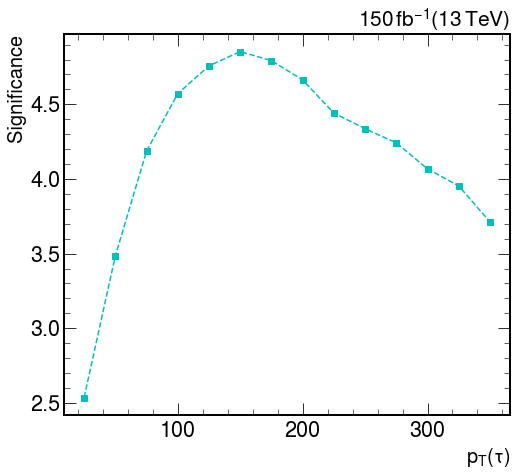

In [14]:
plot_significances(s = Df_s3_cut, 
                   b1 = Df_bgttbar_cut,
                   b2 = Df_bgw_cut,
                   b3 = Df_bgz_cut,
                   var = pt_tau_cut,
                   w = [ex_ev_s[2]] + list(ex_ev_s[3:]),
                   rango = [25, 350, 14], 
                   txt = r'p_T(\tau)');
#plt.xlabel(r'$p_T(\tau)$');

In [15]:
#Applying cuts over the data 
opt = 150

N_ttbar = Df_bgttbar_cut.shape[0]
N_wpj = Df_bgw_cut.shape[0]
N_zpj = Df_bgz_cut.shape[0]

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=0, del_phi = 0, met = 0)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=0, del_phi = 0, met = 0)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=0, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=0, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=0, del_phi = 0, met = 0)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=0, del_phi = 0, met = 0)

N_ttbar2 = Df_bgttbar_cut.shape[0]
N_wpj2 = Df_bgw_cut.shape[0]
N_zpj2 = Df_bgz_cut.shape[0]

In [16]:
#Efficiency p_T(tau) cut
#print(Df_s2_cut.shape[0]/ Df_s2.shape[0])
err = np.array([[N_ttbar2 / N_ttbar, N_ttbar2 / N_ttbar*((N_ttbar2**0.5/N_ttbar2)+(N_ttbar**0.5/N_ttbar))],
                [N_wpj2 / N_wpj, N_wpj2 / N_wpj*((N_wpj2**0.5/N_wpj2)+(N_wpj**0.5/N_wpj))],
                [N_zpj2 / N_zpj, N_zpj2 / N_zpj*((N_zpj2**0.5/N_zpj2)+(N_zpj**0.5/N_zpj))]])

pd.DataFrame(err, columns = ["Measure", "error"], index= ["ttbar", "W+jets", "z+jets"])



,Measure,error
ttbar,0.088735,0.000452
W+jets,0.018315,0.001365
z+jets,0.015433,0.000917


In [17]:
opt = 150

N_ttbar = Df_bgttbar_cut.shape[0]
N_wpj = Df_bgw_cut.shape[0]
N_zpj = Df_bgz_cut.shape[0]

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=20, del_phi = 0, met = 0)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=20, del_phi = 0, met = 0)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=20, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=20, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=20, del_phi = 0, met = 0)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=20, del_phi = 0, met = 0)

N_ttbar2 = Df_bgttbar_cut.shape[0]
N_wpj2 = Df_bgw_cut.shape[0]
N_zpj2 = Df_bgz_cut.shape[0]

In [18]:
#Efficiency p_T(b) cut
#print(Df_s2_cut.shape[0]/ Df_s2.shape[0])
err = np.array([[N_ttbar2 / N_ttbar, N_ttbar2 / N_ttbar*((N_ttbar2**0.5/N_ttbar2)+(N_ttbar**0.5/N_ttbar))],
                [N_wpj2 / N_wpj, N_wpj2 / N_wpj*((N_wpj2**0.5/N_wpj2)+(N_wpj**0.5/N_wpj))],
                [N_zpj2 / N_zpj, N_zpj2 / N_zpj*((N_zpj2**0.5/N_zpj2)+(N_zpj**0.5/N_zpj))]])

pd.DataFrame(err, columns = ["Measure", "error"], index= ["ttbar", "W+jets", "z+jets"])

,Measure,error
ttbar,1.0,0.007848
W+jets,1.0,0.131306
z+jets,1.0,0.105703


In [19]:
opt = 150
omet = 0

N_ttbar = Df_bgttbar_cut.shape[0]
N_wpj = Df_bgw_cut.shape[0]
N_zpj = Df_bgz_cut.shape[0]

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=20, del_phi = 0, met = omet)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=20, del_phi = 0, met = omet)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=20, del_phi = 0, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=20, del_phi = 0, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=20, del_phi = 0, met = omet)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=20, del_phi = 0, met = omet)


Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.electron_pT < 15) | ((Df_bgz_cut.electron_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.electron_pT < 15) | ((Df_bgttbar_cut.electron_pT.isna()))]

Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.muon_pT < 15) | ((Df_bgz_cut.muon_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.muon_pT < 15) | ((Df_bgttbar_cut.muon_pT.isna()))]

N_ttbar2 = Df_bgttbar_cut.shape[0]
N_wpj2 = Df_bgw_cut.shape[0]
N_zpj2 = Df_bgz_cut.shape[0]

In [20]:
#Efficiency e/mu Veto cut
#print(Df_s2_cut.shape[0]/ Df_s2.shape[0])
err = np.array([[N_ttbar2 / N_ttbar, N_ttbar2 / N_ttbar*((N_ttbar2**0.5/N_ttbar2)+(N_ttbar**0.5/N_ttbar))],
                [N_wpj2 / N_wpj, N_wpj2 / N_wpj*((N_wpj2**0.5/N_wpj2)+(N_wpj**0.5/N_wpj))],
                [N_zpj2 / N_zpj, N_zpj2 / N_zpj*((N_zpj2**0.5/N_zpj2)+(N_zpj**0.5/N_zpj))]])

pd.DataFrame(err, columns = ["Measure", "error"], index= ["ttbar", "W+jets", "z+jets"])

,Measure,error
ttbar,0.832984,0.006850
W+jets,1.000000,0.131306
z+jets,0.983240,0.104373


<ipython-input-3-a938f2f49270>:320: RuntimeWarning: invalid value encountered in double_scalars
  sign1 = np.array([var(s, val = i).shape[0] * w[0] \


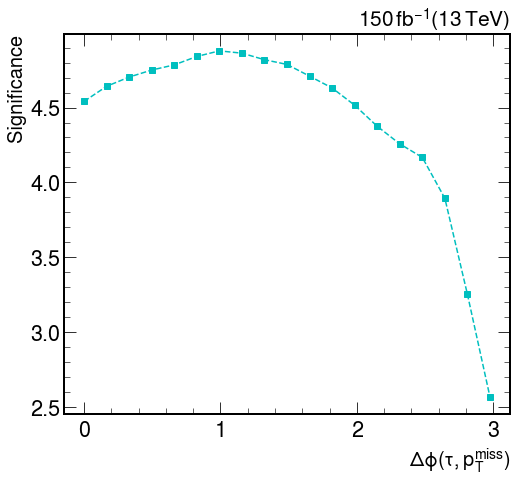

In [21]:
plot_significances(s = Df_s3_cut, 
                   b1 = Df_bgttbar_cut,
                   b2 = Df_bgw_cut,
                   b3 = Df_bgz_cut,
                   var = phi_tau_cut,
                   w = [ex_ev_s[2]] + list(ex_ev_s[3:]),
                   rango = [0, np.pi, 20],
                   txt = r"\Delta\phi(\tau,p_T^{miss})")
#plt.xlabel(r'$\Delta\phi(\tau,p_T^{miss})$');

In [22]:
opt = 150
odp = 1.0

N_ttbar = Df_bgttbar_cut.shape[0]
N_wpj = Df_bgw_cut.shape[0]
N_zpj = Df_bgz_cut.shape[0]

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=20, del_phi = odp, met = 0)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=20, del_phi = odp, met = 0)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=20, del_phi = odp, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=20, del_phi = odp, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=20, del_phi = odp, met = 0)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=20, del_phi = odp, met = 0)


Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.electron_pT < 15) | ((Df_bgz_cut.electron_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.electron_pT < 15) | ((Df_bgttbar_cut.electron_pT.isna()))]

Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.muon_pT < 15) | ((Df_bgz_cut.muon_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.muon_pT < 15) | ((Df_bgttbar_cut.muon_pT.isna()))]

N_ttbar2 = Df_bgttbar_cut.shape[0]
N_wpj2 = Df_bgw_cut.shape[0]
N_zpj2 = Df_bgz_cut.shape[0]

In [23]:
#Efficiency met cut
#print(Df_s2_cut.shape[0]/ Df_s2.shape[0])
err = np.array([[N_ttbar2 / N_ttbar, N_ttbar2 / N_ttbar*((N_ttbar2**0.5/N_ttbar2)+(N_ttbar**0.5/N_ttbar))],
                [N_wpj2 / N_wpj, N_wpj2 / N_wpj*((N_wpj2**0.5/N_wpj2)+(N_wpj**0.5/N_wpj))],
                [N_zpj2 / N_zpj, N_zpj2 / N_zpj*((N_zpj2**0.5/N_zpj2)+(N_zpj**0.5/N_zpj))]])

pd.DataFrame(err, columns = ["Measure", "error"], index= ["ttbar", "W+jets", "z+jets"])

,Measure,error
ttbar,0.611286,0.005989
W+jets,0.681034,0.098892
z+jets,0.727273,0.084218


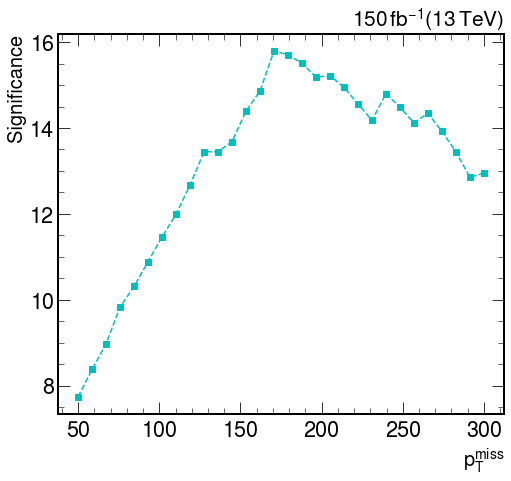

In [24]:
plot_significances(s = Df_s3_cut, 
                   b1 = Df_bgttbar_cut,
                   b2 = Df_bgw_cut,
                   b3 = Df_bgz_cut,
                   var = et_met_cut,
                   w = [ex_ev_s[2]] + list(ex_ev_s[3:]),
                   rango = [50, 300, 30],
                   txt = r"p_T^{miss}")
#plt.xlabel(r'$p_T^{miss}$');

In [25]:
opt = 200
odp = 2
omet = 200


N_ttbar = Df_bgttbar_cut.shape[0]
N_wpj = Df_bgw_cut.shape[0]
N_zpj = Df_bgz_cut.shape[0]

#opt = 80
#odp = 2.4
#omet = 140

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)

Df_bgttbar_cut = Df_bgttbar_cut[Df_bgttbar_cut.num_b == 1]
Df_bgz_cut = Df_bgz_cut[Df_bgz_cut.num_b == 1]
Df_bgw_cut = Df_bgw_cut[Df_bgw_cut.num_b == 1]


Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.electron_pT < 15) | ((Df_bgz_cut.electron_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.electron_pT < 15) | ((Df_bgttbar_cut.electron_pT.isna()))]

Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.muon_pT < 15) | ((Df_bgz_cut.muon_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.muon_pT < 15) | ((Df_bgttbar_cut.muon_pT.isna()))]

Df_s1_cut = Df_s1_cut[(Df_s1_cut.tau2_pT < 50) | ((Df_s1_cut.tau2_pT.isna()))]
Df_s2_cut = Df_s2_cut[(Df_s2_cut.tau2_pT < 50) | ((Df_s2_cut.tau2_pT.isna()))]
Df_s3_cut = Df_s3_cut[(Df_s3_cut.tau2_pT < 50) | ((Df_s3_cut.tau2_pT.isna()))]

Df_bgw_cut = Df_bgw_cut[(Df_bgw_cut.tau2_pT < 50) | ((Df_bgw_cut.tau2_pT.isna()))]
Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.tau2_pT < 50) | ((Df_bgz_cut.tau2_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.tau2_pT < 50) | ((Df_bgttbar_cut.tau2_pT.isna()))]

Df_s1_cut = Df_s1_cut[(np.abs(Df_s1_cut.tau2_eta) > 2.5) | ((Df_s1_cut.tau2_eta.isna()))]
Df_s2_cut = Df_s2_cut[(np.abs(Df_s2_cut.tau2_eta) > 2.5) | ((Df_s2_cut.tau2_eta.isna()))]
Df_s3_cut = Df_s3_cut[(np.abs(Df_s3_cut.tau2_eta) > 2.5) | ((Df_s3_cut.tau2_eta.isna()))]

Df_bgw_cut = Df_bgw_cut[(np.abs(Df_bgw_cut.tau2_eta) > 2.5) | ((Df_bgw_cut.tau2_eta.isna()))]
Df_bgz_cut = Df_bgz_cut[(np.abs(Df_bgz_cut.tau2_eta) > 2.5) | ((Df_bgz_cut.tau2_eta.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(np.abs(Df_bgttbar_cut.tau2_eta) > 2.5) | ((Df_bgttbar_cut.tau2_eta.isna()))]

N_ttbar2 = Df_bgttbar_cut.shape[0]
N_wpj2 = Df_bgw_cut.shape[0]
N_zpj2 = Df_bgz_cut.shape[0]


In [26]:
opt = 200
odp = 2
omet = 200

#opt = 0
#odp = 0
#omet = 0

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)


Df_bgttbar_cut = Df_bgttbar_cut[Df_bgttbar_cut.num_b == 1]
Df_bgz_cut = Df_bgz_cut[Df_bgz_cut.num_b == 1]
Df_bgw_cut = Df_bgw_cut[Df_bgw_cut.num_b == 1]

Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.electron_pT < 15) | ((Df_bgz_cut.electron_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.electron_pT < 15) | ((Df_bgttbar_cut.electron_pT.isna()))]

Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.muon_pT < 15) | ((Df_bgz_cut.muon_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.muon_pT < 15) | ((Df_bgttbar_cut.muon_pT.isna()))]

Df_s1_cut = Df_s1_cut[(Df_s1_cut.tau2_pT < 50) | ((Df_s1_cut.tau2_pT.isna()))]
Df_s2_cut = Df_s2_cut[(Df_s2_cut.tau2_pT < 50) | ((Df_s2_cut.tau2_pT.isna()))]
Df_s3_cut = Df_s3_cut[(Df_s3_cut.tau2_pT < 50) | ((Df_s3_cut.tau2_pT.isna()))]

Df_bgw_cut = Df_bgw_cut[(Df_bgw_cut.tau2_pT < 50) | ((Df_bgw_cut.tau2_pT.isna()))]
Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.tau2_pT < 50) | ((Df_bgz_cut.tau2_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.tau2_pT < 50) | ((Df_bgttbar_cut.tau2_pT.isna()))]

Df_s1_cut = Df_s1_cut[(np.abs(Df_s1_cut.tau2_eta) > 2.3) | ((Df_s1_cut.tau2_eta.isna()))]
Df_s2_cut = Df_s2_cut[(np.abs(Df_s2_cut.tau2_eta) > 2.3) | ((Df_s2_cut.tau2_eta.isna()))]
Df_s3_cut = Df_s3_cut[(np.abs(Df_s3_cut.tau2_eta) > 2.3) | ((Df_s3_cut.tau2_eta.isna()))]

Df_bgw_cut = Df_bgw_cut[(np.abs(Df_bgw_cut.tau2_eta) > 2.3) | ((Df_bgw_cut.tau2_eta.isna()))]
Df_bgz_cut = Df_bgz_cut[(np.abs(Df_bgz_cut.tau2_eta) > 2.3) | ((Df_bgz_cut.tau2_eta.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(np.abs(Df_bgttbar_cut.tau2_eta) > 2.3) | ((Df_bgttbar_cut.tau2_eta.isna()))]


df = pd.DataFrame(ex_ev_s, columns = ["expected_events"])
df['First_Selection'] = np.array([Df_s1.shape[0], Df_s2.shape[0], Df_s3.shape[0],
                                  Df_bg_ttbar.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]]) 
df['Second_Selection'] = np.array([Df_s1_cut.shape[0], Df_s2_cut.shape[0], Df_s3_cut.shape[0], 
                                   Df_bgttbar_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]]) 
df

,expected_events,First_Selection,Second_Selection
eps_l = 1,0.195000,9727,1170
eps_s = 1,0.120000,9202,1708
eps_t = 1,1.065000,12371,916
Bg_TTbar,3.114478,1354204,462
Bg_WJ,1049.631418,19361,1
Bg_ZJ,348.780924,44747,3


In [27]:
df = pd.DataFrame(ex_ev_s, columns = ["expected_events"])
df['First_Selection'] = np.array([Df_s1.shape[0], Df_s2.shape[0], Df_s3.shape[0],
                                  Df_bg_ttbar.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]]) *ex_ev_s
df['Second_Selection'] = np.array([Df_s1_cut.shape[0], Df_s2_cut.shape[0], Df_s3_cut.shape[0], 
                                   Df_bgttbar_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]]) *ex_ev_s
df

,expected_events,First_Selection,Second_Selection
eps_l = 1,0.195000,1.896765e+03,228.150000
eps_s = 1,0.120000,1.104240e+03,204.960000
eps_t = 1,1.065000,1.317511e+04,975.540000
Bg_TTbar,3.114478,4.217639e+06,1438.888924
Bg_WJ,1049.631418,2.032191e+07,1049.631418
Bg_ZJ,348.780924,1.560690e+07,1046.342772


In [27]:
#Final Eficiencies
err = np.array([[N_ttbar2 / N_ttbar, N_ttbar2 / N_ttbar*((N_ttbar2**0.5/N_ttbar2)+(N_ttbar**0.5/N_ttbar))],
                [N_wpj2 / N_wpj, N_wpj2 / N_wpj*((N_wpj2**0.5/N_wpj2)+(N_wpj**0.5/N_wpj))],
                [N_zpj2 / N_zpj, N_zpj2 / N_zpj*((N_zpj2**0.5/N_zpj2)+(N_zpj**0.5/N_zpj))]])

pd.DataFrame(err, columns = ["Measure", "error"], index= ["ttbar", "W+jets", "z+jets"])

,Measure,error
ttbar,0.013909,0.000725
W+jets,0.006329,0.006833
z+jets,0.011719,0.007498


In [17]:
df = pd.DataFrame(ex_ev_s, columns = ["expected_events"])
df['First_Selection'] = np.array([Df_s1.shape[0], Df_s2.shape[0], Df_s3.shape[0],
                                  Df_bg_ttbar.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]]) * ex_ev_s
df['Second_Selection'] = np.array([Df_s1_cut.shape[0], Df_s2_cut.shape[0], Df_s3_cut.shape[0], 
                                   Df_bgttbar_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]]) * ex_ev_s 
df

,expected_events,First_Selection,Second_Selection
eps_l = 1,0.195000,1.896765e+03,228.150000
eps_s = 1,0.120000,1.104240e+03,204.960000
eps_t = 1,1.065000,1.317511e+04,975.540000
Bg_TTbar,3.114478,4.217639e+06,1438.888924
Bg_WJ,1049.631418,2.032191e+07,1049.631418
Bg_ZJ,348.780924,1.560690e+07,1046.342772


In [29]:
N_Back = df.Second_Selection[3:]
Z = df.Second_Selection[:3] / (df.Second_Selection[:3] + N_Back.sum()) ** 0.5
Z

eps_l = 1     3.719226
eps_s = 1     3.351534
eps_t = 1    14.525711
Name: Second_Selection, dtype: float64

# Plotting and Results

The plots cells are:
1. Plots for the first 3 jets kinematic variables.
2. Plots for the Met variables before the selection.
3. Plots for the Met variables after the selection.
4. Plots for the kinematic variables of $\tau_h$ and $b_{jet}$.
5. Mass spectras.

In [30]:
N_mc1 = np.array([Df_s1.shape[0], Df_s2.shape[0], Df_s3.shape[0],
                  Df_bg_ttbar.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]])
N_mc2 = np.array([Df_s1_cut.shape[0], Df_s2_cut.shape[0], Df_s3_cut.shape[0], 
                  Df_bgttbar_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]])

s_err1 = pd.Series(ex_ev_s *(N_mc1)**0.5, name = "First_Selection")
s_err2 = pd.Series(ex_ev_s *(N_mc2)**0.5, name = "Second_Selection")
s_err2

eps_l = 1       6.670026
eps_s = 1       4.959355
eps_t = 1      32.232749
Bg_TTbar       66.943171
Bg_WJ        1049.631418
Bg_ZJ         604.106281
Name: Second_Selection, dtype: float64

In [31]:
df2 = pd.DataFrame(data = df ** 0.5).drop(columns=['expected_events'])
df2

,First_Selection,Second_Selection
eps_l = 1,43.551866,15.104635
eps_s = 1,33.230107,14.316424
eps_t = 1,114.782904,31.233636
Bg_TTbar,2053.689077,37.932689
Bg_WJ,4507.983350,32.398016
Bg_ZJ,3950.556923,32.347222


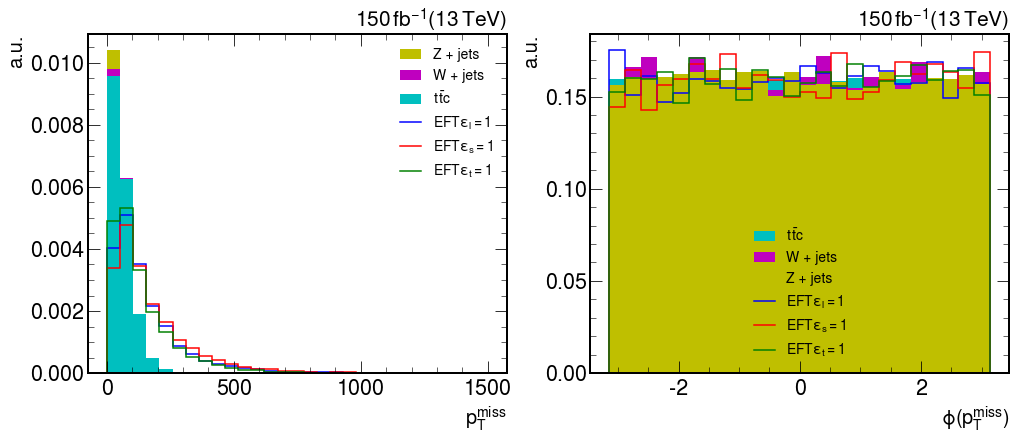

In [32]:
plot_Met_ET_Phi2(df1 = Df_s1, 
                 df2 = Df_s2, 
                 df3 = Df_s3, 
                 bg2 = Df_bg_wj, 
                 bg3 = Df_bg_zj, 
                 bg1 = Df_bg_ttbar,
                 size = 14,
                 labels = labels)

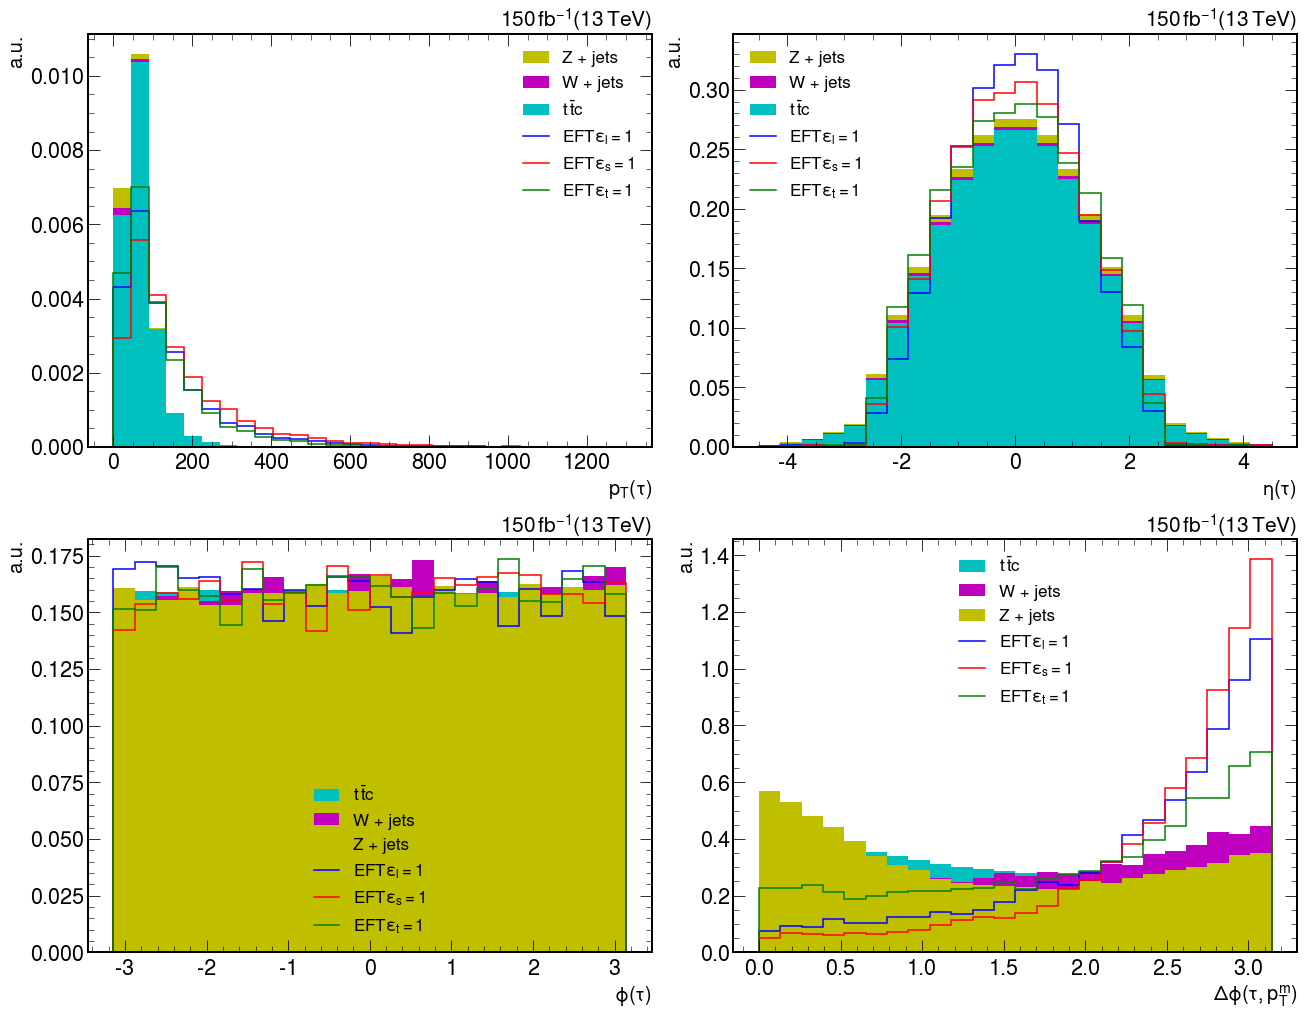

In [33]:
#Pt Eta phi and delta phi with met for the b
plot_pt_eta_phi2(labels= labels,
                 obj = "tau1", 
                 df1 = Df_s1, 
                 df2 = Df_s2, 
                 df3 = Df_s3,
                 bg2 = Df_bg_wj, 
                 bg3 = Df_bg_zj, 
                 bg1 = Df_bg_ttbar,
                 size = 17)

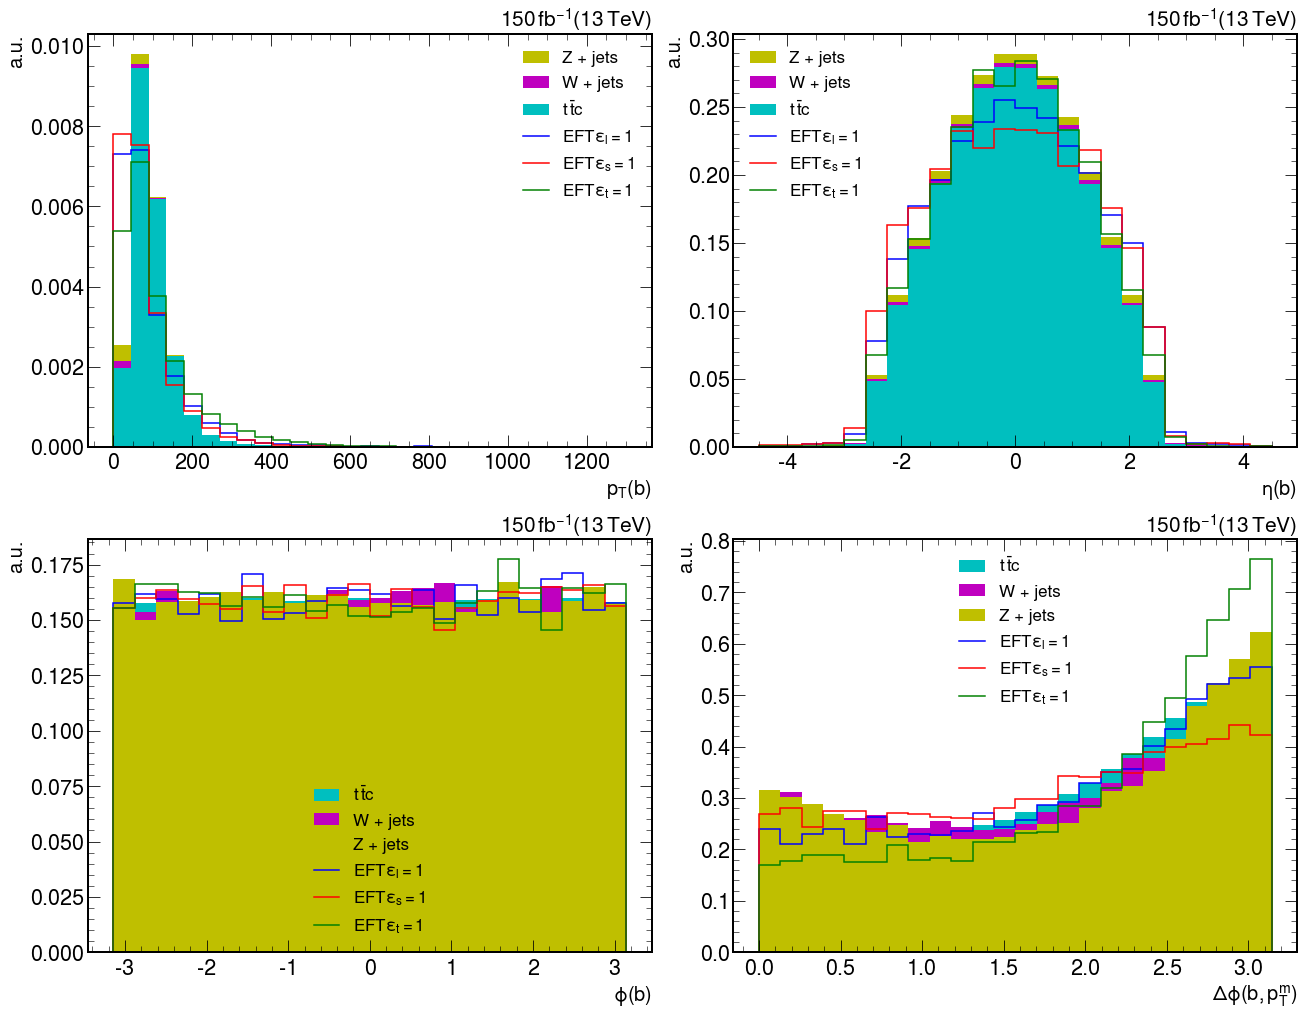

In [34]:
#Pt Eta phi and delta phi with met for the b
plot_pt_eta_phi2(labels= labels,
                 obj = "b", 
                 df1 = Df_s1, 
                 df2 = Df_s2, 
                 df3 = Df_s3,
                 bg2 = Df_bg_wj, 
                 bg3 = Df_bg_zj, 
                 bg1 = Df_bg_ttbar,
                 size = 17)

In [28]:
def plot_mass2(m_type,s1,s2,s3,bg1,bg2,bg3, Ws, labels, bines = [30], labs_sizes = 20):
    """
    Returns a mass distributions for 3 signals and tree backgrounds
    Parameters:
        m_type: A string that will serve for the plot's x_label.
        s1 : Signal#1, a series or iterable to be binned.
        s2 : Signal#2, a series or iterable to be binned.
        s3 : Signal#3, a series or iterable to be binned.
        bg1 : Background#1, a series or iterable to be binned.
        bg2 : Background#2, a series or iterable to be binned.
        bg3 : Background#3, a series or iterable to be binned.
        Ws : The weights of the signal and background 
             in the order they are implemented in the function.
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        bines : bins for each histogram. Eachone must be a iterable of the edges of the bins
                ordered betweeen the minimun and the maximun value of the histograms
             
    """
    f, axs = plt.subplots( figsize=(9, 7))

    h1, binss1 = np.histogram(s1, bines)
    h2, binss2 = np.histogram(s2, bines)
    h3, binss3 = np.histogram(s3, bines)

    h4, binsb1 = np.histogram(bg1, bines)
    h5, binsb2 = np.histogram(bg2, bines)
    h6, binsb3 = np.histogram(bg3, bines)

    
    hep.histplot([h4 * Ws[3]/ bg1.shape[0], h5 * Ws[4] /bg2.shape[0], h6 * Ws[5] /bg3.shape],
                 bins = binss3, 
                 ax = axs,
                 color = ['c', 'm', 'y'],  
                 stack = True, 
                 histtype = 'fill', 
                 label = labels[3:],
                 sort='label_r')
    
    hep.histplot((h6 * Ws[5]/ bg3.shape[0]) + (h5 * Ws[4]/ bg2.shape[0]) + (h4 * Ws[3]/ bg1.shape[0]),
                 bins = binss3,
                 ax=axs, 
                 histtype='errorbar',
                 #hatch = '///',
                 yerr=True, 
                 c='black',
                 marker="",
                 capsize=4, 
                 label = 'background err')
    
    hep.histplot(h1 * Ws[0]/ s1.shape[0],
                 bins = binss1,
                 ax = axs,
                 yerr = True,
                 color = 'b',
                 histtype = 'step',  
                 label = labels[0])
    hep.histplot(h2 * Ws[1]/ s2.shape[0],
                 bins = binss1,
                 ax = axs,
                 yerr = True,
                 color = 'r',
                 histtype = 'step',  
                 label = labels[1])
    hep.histplot(h3 * Ws[2]/ s3.shape[0],
                 bins = binss1,
                 ax = axs,
                 yerr = True,
                 color = 'g',
                 histtype = 'step',  
                 label = labels[2])

    #hep.cms.label()
    axs.set_xlabel(m_type, fontsize = labs_sizes)
    axs.set_ylabel('Events',fontsize = labs_sizes)
    axs.set_yscale("log")
    axs.legend(fontsize = 'xx-small', loc = 'upper right')
    axs.set_title(r'$100 \,fb^{-1}(13 \,TeV)$', loc = 'right', fontsize = labs_sizes + 1)
    #f.savefig(f'{Path_files}/{m_type}');

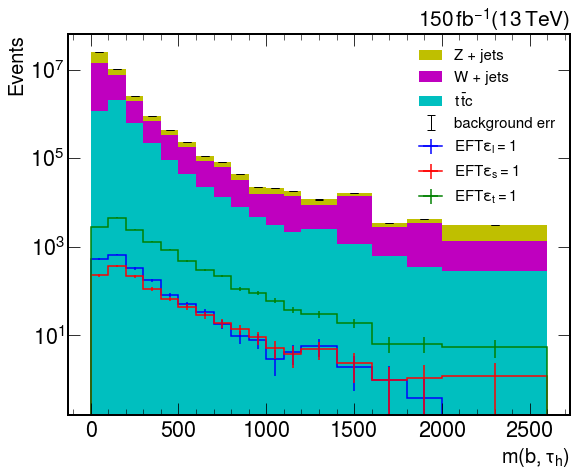

In [29]:
#Invariant Mass between tau, b without cuts
m_tau_b1 = generate_ploteable_invariant_masses(Df_s1,Df_s2, Df_s3)
m_tau_bg = generate_ploteable_invariant_masses(Df_bg_ttbar, Df_bg_wj, Df_bg_zj)
Df_s1['Invariant_mass_tau_b'], Df_s2['Invariant_mass_tau_b'], Df_s3['Invariant_mass_tau_b'] = m_tau_b1
Df_bg_ttbar['Invariant_mass_tau_b'], Df_bg_wj['Invariant_mass_tau_b'], Df_bg_zj['Invariant_mass_tau_b'] = m_tau_bg

plot_mass1(m_type = r'$m(b,\tau_h)$',
           s1 = Df_s1['Invariant_mass_tau_b'],
           s2 = Df_s2['Invariant_mass_tau_b'],
           s3 = Df_s3['Invariant_mass_tau_b'],
           bg1 = Df_bg_ttbar['Invariant_mass_tau_b'],
           bg2 = Df_bg_wj['Invariant_mass_tau_b'],
           bg3 = Df_bg_zj['Invariant_mass_tau_b'],
           Ws = df.First_Selection,
           labels= labels,
           bines = [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600])

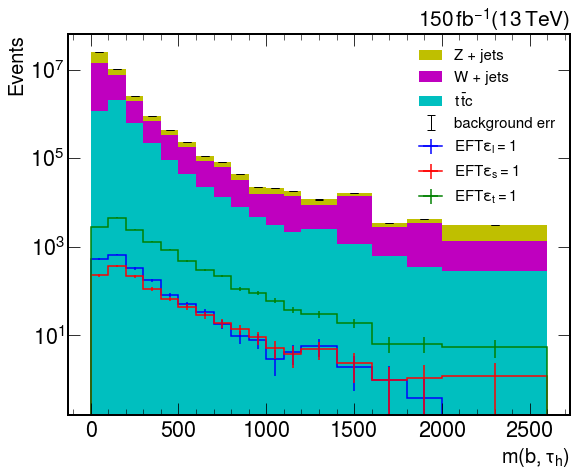

In [30]:
#Invariant Mass between tau, b without cuts
m_tau_b1 = generate_ploteable_invariant_masses(Df_s1,Df_s2, Df_s3)
m_tau_bg = generate_ploteable_invariant_masses(Df_bg_ttbar, Df_bg_wj, Df_bg_zj)
Df_s1['Invariant_mass_tau_b'], Df_s2['Invariant_mass_tau_b'], Df_s3['Invariant_mass_tau_b'] = m_tau_b1
Df_bg_ttbar['Invariant_mass_tau_b'], Df_bg_wj['Invariant_mass_tau_b'], Df_bg_zj['Invariant_mass_tau_b'] = m_tau_bg

plot_mass1(m_type = r'$m(b,\tau_h)$',
           s1 = Df_s1['Invariant_mass_tau_b'],
           s2 = Df_s2['Invariant_mass_tau_b'],
           s3 = Df_s3['Invariant_mass_tau_b'],
           bg1 = Df_bg_ttbar['Invariant_mass_tau_b'],
           bg2 = Df_bg_wj['Invariant_mass_tau_b'],
           bg3 = Df_bg_zj['Invariant_mass_tau_b'],
           Ws = df.First_Selection,
           labels= labels,
           bines = [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600])
            


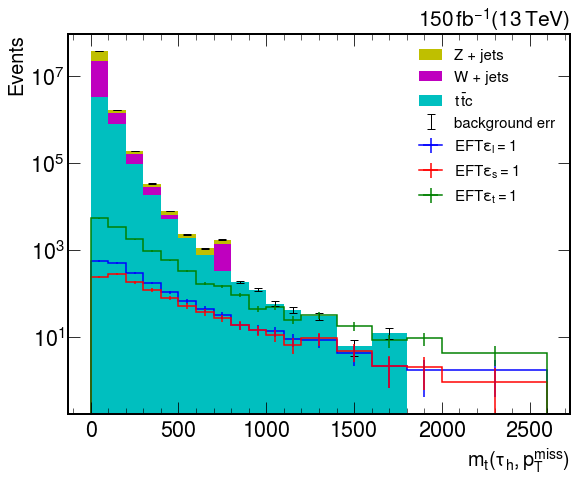

In [31]:
#Transverse mass of tau without cuts
m_trvs_tau_nu1 = generate_ploteable_tr_tau_nu_masses(Df_s1,Df_s2, Df_s3)
m_trvs_tau_nu2 = generate_ploteable_tr_tau_nu_masses(Df_bg_ttbar, Df_bg_wj,Df_bg_zj)
Df_s1['Transverse_mass_tau'], Df_s2['Transverse_mass_tau'], Df_s3['Transverse_mass_tau'] = m_trvs_tau_nu1
Df_bg_ttbar['Transverse_mass_tau'], Df_bg_wj['Transverse_mass_tau'], Df_bg_zj['Transverse_mass_tau'] = m_trvs_tau_nu2

plot_mass1(m_type = r'$m_t(\tau_h, p_T^{miss})$',
           s1 = Df_s1['Transverse_mass_tau'],
           s2 = Df_s2['Transverse_mass_tau'],
           s3 = Df_s3['Transverse_mass_tau'],
           bg1 = Df_bg_ttbar['Transverse_mass_tau'],
           bg2 = Df_bg_wj['Transverse_mass_tau'],
           bg3 = Df_bg_zj['Transverse_mass_tau'],
           Ws = df.First_Selection,
           labels= labels,
           bines = [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600])


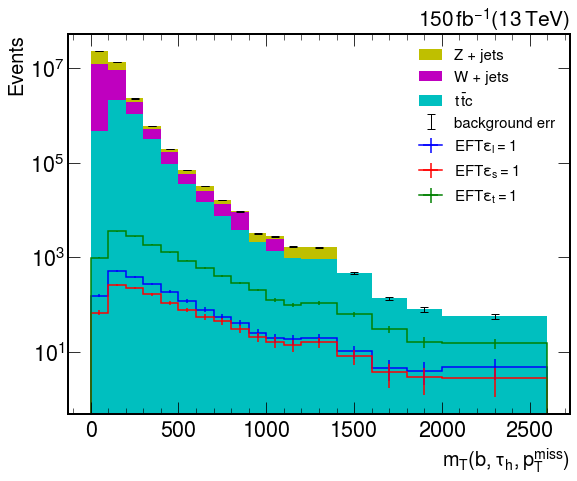

In [32]:
#Total mass between b tau nu without cuts
m_T1 = generate_ploteable_total_masses(Df_s1, Df_s2, Df_s3)
m_Tbg = generate_ploteable_total_masses(Df_bg_ttbar, Df_bg_wj, Df_bg_zj)
Df_s1['Total_mass'], Df_s2['Total_mass'], Df_s3['Total_mass'] = m_T1
Df_bg_ttbar['Total_mass'], Df_bg_wj['Total_mass'], Df_bg_zj['Total_mass'] = m_Tbg


plot_mass1(m_type = r'$m_T(b,\tau_h, p_T^{miss})$',
           s1 = Df_s1['Total_mass'],
           s2 = Df_s2['Total_mass'],
           s3 = Df_s3['Total_mass'],
           bg1 = Df_bg_ttbar['Total_mass'],
           bg2 = Df_bg_wj['Total_mass'],
           bg3 = Df_bg_zj['Total_mass'],
           Ws = df.First_Selection,
           labels= labels,
           bines = [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600])

In [33]:
opt = 200
odp = 2
omet = 200


#opt = 80
#odp = 2.4
#omet = 140

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=20, del_phi = odp, met = omet)


Df_bgttbar_cut = Df_bgttbar_cut[Df_bgttbar_cut.num_b == 1]
Df_bgz_cut = Df_bgz_cut[Df_bgz_cut.num_b == 1]
Df_bgw_cut = Df_bgw_cut[Df_bgw_cut.num_b == 1]

Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.electron_pT < 15) | ((Df_bgz_cut.electron_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.electron_pT < 15) | ((Df_bgttbar_cut.electron_pT.isna()))]

Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.muon_pT < 15) | ((Df_bgz_cut.muon_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.muon_pT < 15) | ((Df_bgttbar_cut.muon_pT.isna()))]

Df_s1_cut = Df_s1_cut[(Df_s1_cut.tau2_pT < 50) | ((Df_s1_cut.tau2_pT.isna()))]
Df_s2_cut = Df_s2_cut[(Df_s2_cut.tau2_pT < 50) | ((Df_s2_cut.tau2_pT.isna()))]
Df_s3_cut = Df_s3_cut[(Df_s3_cut.tau2_pT < 50) | ((Df_s3_cut.tau2_pT.isna()))]

Df_bgw_cut = Df_bgw_cut[(Df_bgw_cut.tau2_pT < 50) | ((Df_bgw_cut.tau2_pT.isna()))]
Df_bgz_cut = Df_bgz_cut[(Df_bgz_cut.tau2_pT < 50) | ((Df_bgz_cut.tau2_pT.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(Df_bgttbar_cut.tau2_pT < 50) | ((Df_bgttbar_cut.tau2_pT.isna()))]

Df_s1_cut = Df_s1_cut[(np.abs(Df_s1_cut.tau2_eta) > 2.3) | ((Df_s1_cut.tau2_eta.isna()))]
Df_s2_cut = Df_s2_cut[(np.abs(Df_s2_cut.tau2_eta) > 2.3) | ((Df_s2_cut.tau2_eta.isna()))]
Df_s3_cut = Df_s3_cut[(np.abs(Df_s3_cut.tau2_eta) > 2.3) | ((Df_s3_cut.tau2_eta.isna()))]

Df_bgw_cut = Df_bgw_cut[(np.abs(Df_bgw_cut.tau2_eta) > 2.3) | ((Df_bgw_cut.tau2_eta.isna()))]
Df_bgz_cut = Df_bgz_cut[(np.abs(Df_bgz_cut.tau2_eta) > 2.3) | ((Df_bgz_cut.tau2_eta.isna()))]
Df_bgttbar_cut = Df_bgttbar_cut[(np.abs(Df_bgttbar_cut.tau2_eta) > 2.3) | ((Df_bgttbar_cut.tau2_eta.isna()))]


df = pd.DataFrame(ex_ev_s, columns = ["expected_events"])
df['First_Selection'] = np.array([Df_s1.shape[0], Df_s2.shape[0], Df_s3.shape[0],
                                  Df_bg_ttbar.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]]) * ex_ev_s
df['Second_Selection'] = np.array([Df_s1_cut.shape[0], Df_s2_cut.shape[0], Df_s3_cut.shape[0], 
                                   Df_bgttbar_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]]) * ex_ev_s 
df

,expected_events,First_Selection,Second_Selection
eps_l = 1,0.195000,1.896765e+03,228.150000
eps_s = 1,0.120000,1.104240e+03,204.960000
eps_t = 1,1.065000,1.317511e+04,975.540000
Bg_TTbar,3.114478,4.217639e+06,1438.888924
Bg_WJ,1049.631418,2.032191e+07,1049.631418
Bg_ZJ,348.780924,1.560690e+07,1046.342772


In [34]:
def plot_mass3(m_type,s1,s2,s3,bg1,bg2,bg3, Ws, labels, bines = [30], labs_sizes = 20):
    """
    Returns a mass distributions for 3 signals and tree backgrounds
    Parameters:
        m_type: A string that will serve for the plot's x_label.
        s1 : Signal#1, a series or iterable to be binned.
        s2 : Signal#2, a series or iterable to be binned.
        s3 : Signal#3, a series or iterable to be binned.
        bg1 : Background#1, a series or iterable to be binned.
        bg2 : Background#2, a series or iterable to be binned.
        bg3 : Background#3, a series or iterable to be binned.
        Ws : The weights of the signal and background 
             in the order they are implemented in the function.
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        bines : bins for each histogram. Eachone must be a iterable of the edges of the bins
                ordered betweeen the minimun and the maximun value of the histograms
             
    """
    #f, axs = plt.subplots( figsize=(9, 7))

    h1, binss1 = np.histogram(s1, bines)
    h2, binss2 = np.histogram(s2, bines)
    h3, binss3 = np.histogram(s3, bines)

    h4, binsb1 = np.histogram(bg1, bines)
    h5, binsb2 = np.histogram(bg2, bines)
    h6, binsb3 = np.histogram(bg3, bines)

    df = pd.DataFrame([h1 * Ws[0]/ s1.shape[0],
                       h2 * Ws[1]/ s2.shape[0],
                       h3 * Ws[2]/ s3.shape[0],
                       h4 * Ws[3]/ bg1.shape[0], 
                       h5 * Ws[4] /bg2.shape[0], 
                       h6 * Ws[5] /bg3.shape[0]],
                     index = labels)
    return df, binss1

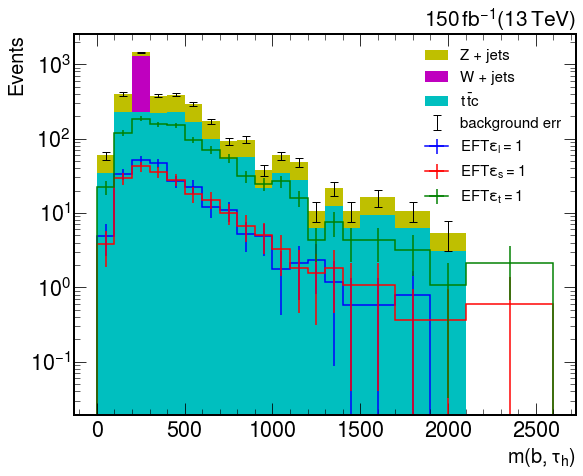

In [35]:
# Invariant Mass between tau, b with cuts

plot_mass1(m_type = r'$m(b,\tau_h)$',
           s1 = Df_s1_cut['Invariant_mass_tau_b'],
           s2 = Df_s2_cut['Invariant_mass_tau_b'],
           s3 = Df_s3_cut['Invariant_mass_tau_b'],
           bg1 = Df_bgttbar_cut['Invariant_mass_tau_b'],
           bg2 = Df_bgw_cut['Invariant_mass_tau_b'],
           bg3 = Df_bgttbar_cut['Invariant_mass_tau_b'],
           Ws = df.Second_Selection,
           labels= labels,
           bines = [i for i in range(0,1500,100)] + [i for i in range(1500, 2200,200)]+[2600])


In [36]:
labels

['EFT$\\epsilon_l = 1$',
 'EFT$\\epsilon_s = 1$',
 'EFT$\\epsilon_t = 1$',
 '$t\\,\\bar{t}$c',
 'W + jets',
 'Z + jets']

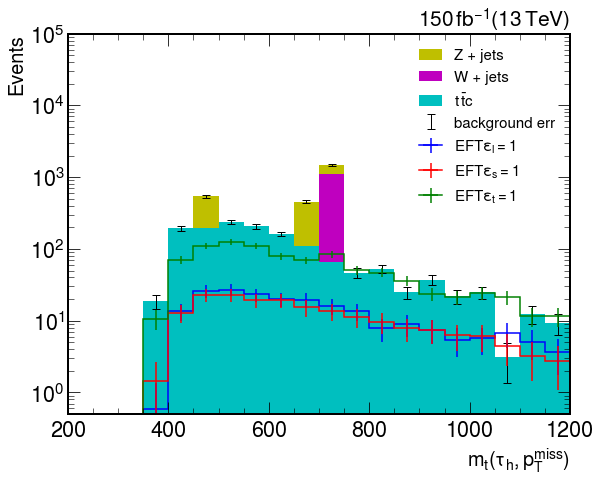

In [37]:
#Transverse mass of tau with cuts

plot_mass1(m_type = r'$m_t(\tau_h, p_T^{miss})$',
           s1 = Df_s1_cut['Transverse_mass_tau'],
           s2 = Df_s2_cut['Transverse_mass_tau'],
           s3 = Df_s3_cut['Transverse_mass_tau'],
           bg1 = Df_bgttbar_cut['Transverse_mass_tau'],
           bg2 = Df_bgw_cut['Transverse_mass_tau'],
           bg3 = Df_bgz_cut['Transverse_mass_tau'],
           Ws = df.Second_Selection,
           labels= labels,
           bines = [i for i in range(0,1200,50)] + [i for i in range(1200, 2200,100)]+[2600])
plt.xlim(200,1200)
plt.ylim(0.5,1e5);
#plt.savefig(Path_files + '/$m_t(\tau_h, p_T^{miss})$');

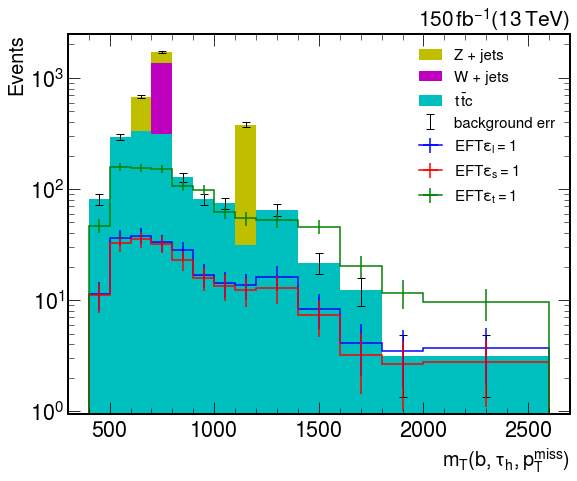

In [45]:
plot_mass1(m_type = r'$m_T(b,\tau_h, p_T^{miss})$',
           s1 = Df_s1_cut['Total_mass'],
           s2 = Df_s2_cut['Total_mass'],
           s3 = Df_s3_cut['Total_mass'],
           bg1 = Df_bgttbar_cut['Total_mass'],
           bg2 = Df_bgw_cut['Total_mass'],
           bg3 = Df_bgz_cut['Total_mass'],
           Ws = df.Second_Selection,
           labels= labels,
           bines = [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600])
#plt.legend(loc= 'center right', fontsize = 14)
plt.xlim(300,2700);
#plt.savefig(Path_files + '/$m_T(b,\tau_h, p_T^{miss})$');

In [39]:
df_tot, bines = plot_mass3(m_type = r'$m_T(b,\tau_h, p_T^{miss})$',
                           s1 = Df_s1_cut['Total_mass'],
                           s2 = Df_s2_cut['Total_mass'],
                           s3 = Df_s3_cut['Total_mass'],
                           bg1 = Df_bgttbar_cut['Total_mass'],
                           bg2 = Df_bgw_cut['Total_mass'],
                           bg3 = Df_bgz_cut['Total_mass'],
                           Ws = df.Second_Selection,
                           labels= labels,
                           bines = [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600])

In [40]:
df_tot.apply(sum, axis = 1)

EFT$\epsilon_l = 1$     227.760000
EFT$\epsilon_s = 1$     204.840000
EFT$\epsilon_t = 1$     970.215000
$t\,\bar{t}$c          1435.774446
W + jets               1049.631418
Z + jets               1046.342772
dtype: float64

In [48]:
df_tot.loc[r"$t\,\bar{t}$c"]

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4      80.976433
5     292.760950
6     330.134688
7     311.447819
8     127.693606
9      80.976433
10     74.747477
11     31.144782
12     65.404042
13     21.801347
14     12.457913
15      3.114478
16      3.114478
Name: $t\,\bar{t}$c, dtype: float64